# Data preprocessing

Notebook to preprocess and clean the dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import folium
from IPython.display import display
from scipy.stats import chi2_contingency
from scipy.stats import skew


In [2]:
# notebook settings
%matplotlib inline
pd.options.display.max_columns = None
sns.set_theme()

In [3]:
# load dataset
water_pump_data = pd.read_csv('../data/raw/water_pump_dataset.csv', sep=';', parse_dates=['date_recorded'])
display(water_pump_data.head())
print(water_pump_data.columns)
print(water_pump_data.shape)

/tmp/ipykernel_20879/875887398.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  water_pump_data = pd.read_csv('../data/raw/water_pump_dataset.csv', sep=';', parse_dates=['date_recorded'])


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,3.493.809.275,-985.632.177,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-06-03,Grumeti,1399,GRUMETI,346.987.661,-214.746.569,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,3.746.066.446,-382.132.853,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,3.848.616.088,-1.115.529.772,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,3.113.084.671,-182.535.885,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')
(59400, 41)


# 1. Solve data corruption in lat lon columns


The latitude and longitude columns looks corrupted (unwanted changes during storage or processing). I found the [original dataset](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/) to retrieve the correct lat/lon columns.

In [4]:
# original lat lon values
water_pump_data_original = pd.read_csv('../data/external/water_pump_original.csv', parse_dates=['date_recorded'])

water_pump_data['longitude']=water_pump_data_original['longitude']
water_pump_data['latitude']=water_pump_data_original['latitude']

# check
display(water_pump_data.head())

# check whether rest of the dataset is the same
# get column names for each dataframe
cols1 = set(water_pump_data_original.columns)
cols2 = set(water_pump_data.iloc[:, :-1].columns)

# find columns that are different
diff_cols = cols1.symmetric_difference(cols2)
print(diff_cols)



,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-06-03,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


set()


# 2. Missing values


First I get an overview of missing data and type. Then I will deal with the missing values according to their dtype (continuous or categorical).

In [5]:
def count_missing_values(dataframe):
    
    # create a dataframe mask indicating missing values
    mask = water_pump_data.isnull()

    # count the number of missing values in each column
    missing = mask.sum()

    # get the data types of the columns
    dtypes = dataframe.dtypes

    # combine missing values and data types into a single dataframe
    missing_result = pd.DataFrame({'missing': missing, 'dtype': dtypes})
    
    display(missing_result)

In [6]:
count_missing_values(water_pump_data)

,missing,dtype
id,0,int64
amount_tsh,0,float64
date_recorded,0,datetime64[ns]
funder,3635,object
gps_height,0,int64
installer,3655,object
longitude,0,float64
latitude,0,float64
wpt_name,0,object
num_private,0,int64


## 2.1 Continuous columns

All missing values seem to be in the categorical columns. There are columns that have 0 values, which might indicate missing.

In [7]:
# get description of continuous variables
water_pump_data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [8]:
# loop over continuous columns and count values equal to 0
print("Column name with number of 0 values")
for col in water_pump_data.select_dtypes(include='number'):
    num_zeros = (water_pump_data[col] == 0).sum()
    print(f"{col}: {num_zeros} ")


Column name with number of 0 values
id: 1 
amount_tsh: 41639 
gps_height: 20438 
longitude: 1812 
latitude: 0 
num_private: 58643 
region_code: 0 
district_code: 23 
population: 21381 
construction_year: 20709 


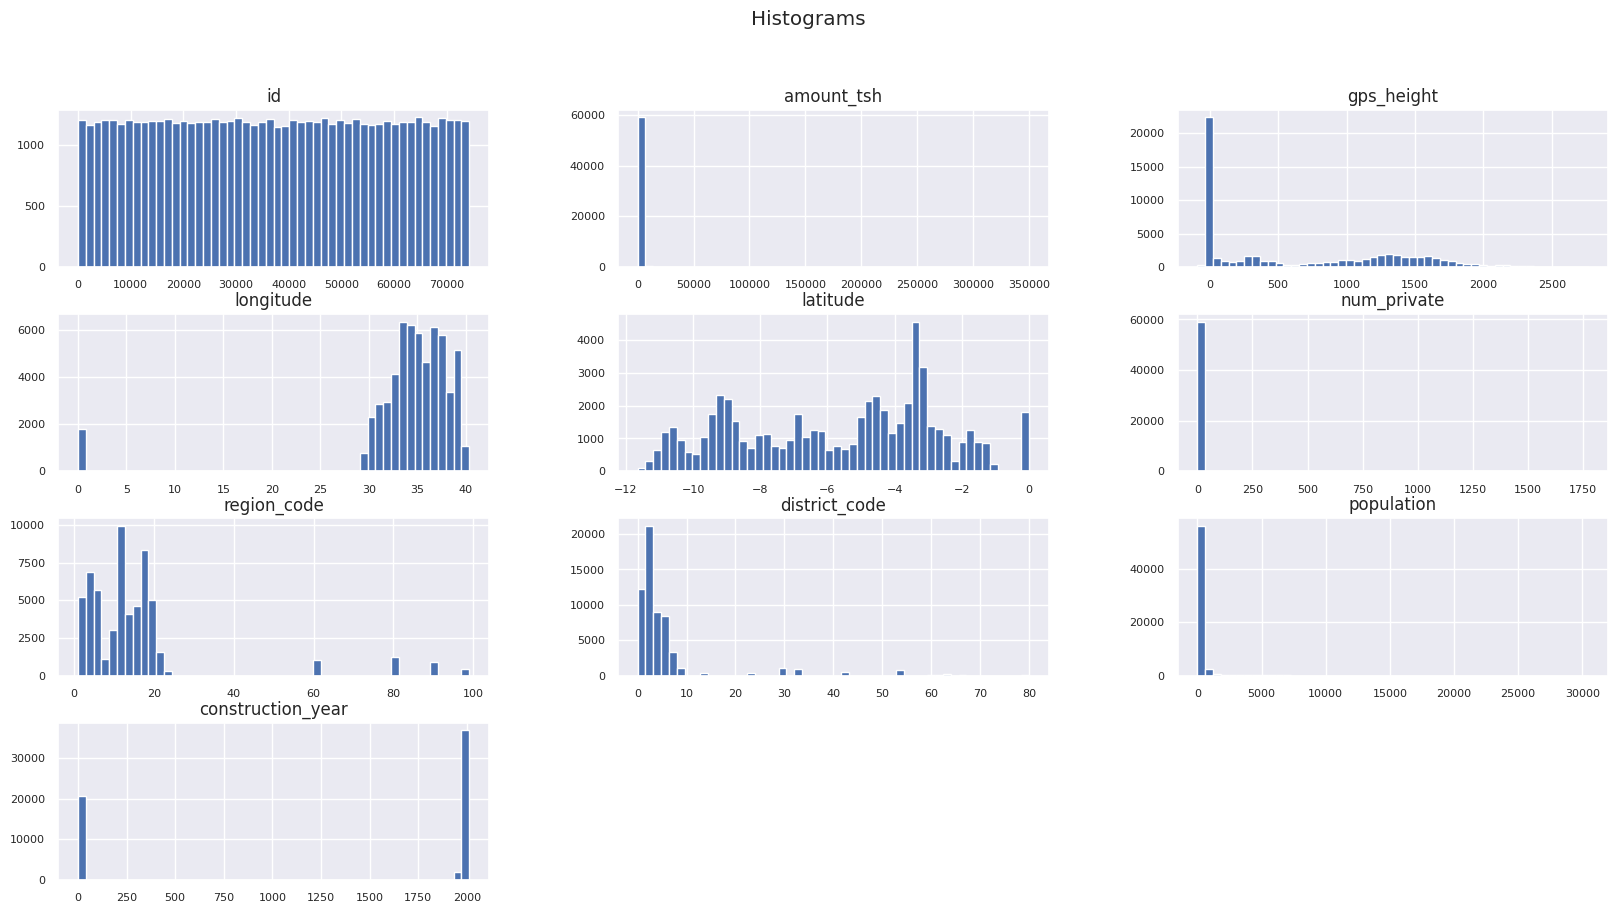

In [9]:
# plot histograms of the columns

cont_cols = list(water_pump_data.select_dtypes(include='number').columns)

water_pump_data.hist(column=cont_cols, bins=50, figsize=(20, 10), xlabelsize=8, ylabelsize=8)

# add a title and labels to the plot
plt.suptitle('Histograms')
plt.xlabel('Values')
plt.ylabel('Frequency')

# display the plot
plt.show()

### Strategies

For dealing with continuous missing data, we can use one of the following strategies.

1. Delete missing values, either per row (listwise, using `df.dropna(axis=0)` or per column `df.drop([[columns_with_many_missing_values]], axis=1)`
2. Replace with previous value or backward fill`df.fillna(method='bfill')` 
3. Replace with next value or forward fill `df.fillna(method='ffill')`)
4. Replace with arbitrary value based on domain knowledge `df.fillna(value=1)`)
5. Interpolation, methods include ‘polynomial,’ ‘linear,’ and ‘quadratic.’ Default is linear (`df.interpolate`)
6. Replace with mean `df[col].fillna(df[col].mean())`
7. Replace with median `df[col].fillna(df[col].median())`
8. Replace with mode `df[col].fillna(df[col].mode()[0])`
9. Do nothing (let algorithm handle the missing data, like XGBoost that learn the best imputation methods or others have option to just ignore them). 
10.Zero or Constant imputation: it replaces the missing values with either zero or any constant value `df.fillna(value=0)`


Below an overview of all continuous variables and how to deal with missing values if needed. 0 indicates that there is no missing data and requires no action.

| Column | Meaning | Strategy # | Comment|
| --- | --- | --- | --- | 
| id | index | 9 | unique for each observation. Drop column later.|
| amount_tsh | total static head (amount water available to waterpoint) | 9 | lot's of 0's, might be an important feature, leaving as it is |
| gps_height | altitude to the well | 7 | Can the altitude be 0? Replace with median |
| num_private | unknown | 9 | lot's of 0's, but not sure about meaning. |
| region_code | geographic location (coded)| 0 | no missing data | 
| district_code | geographic location (coded | 9 | missing values can be partly captured by other geographical variables |
| population | population around the well | 6,7 | step 1. Get region and calculate the mean population from region. Step 2: impute rest with the median of the column|
| construction_year | year waterpoint was constructed | 9 | No other information, leaving as it is|
| longitude | GPS coordinate | 6, 7 | step 1. Get region and calculate the mean longitude from region. Step 2: impute rest with the median of the column|
| latitude | GPS coordinate | 6,7 | step 1. Get region and calculate the mean longitude from region. Step 2: impute rest with the median of the column|


Note that a region is below the area and above the district in the organizational hierarchy.
Note that region_code and district_code are categorical and encoded. Construction year is a time variable. Lat and lon are gps coordinates.

In [10]:
# 1. ID
# To drop later
# water_pump_data.drop(['id'], axis=1, inplace=True)
# print(water_pump_data.shape)

In [11]:
# 2. amount_tsh

# Median and mode are 0. Taking mean doesn't make sense because of so many 0's.
# Options are to drop whole column, replace with mean or leave it as it is. Leaving it for now. 


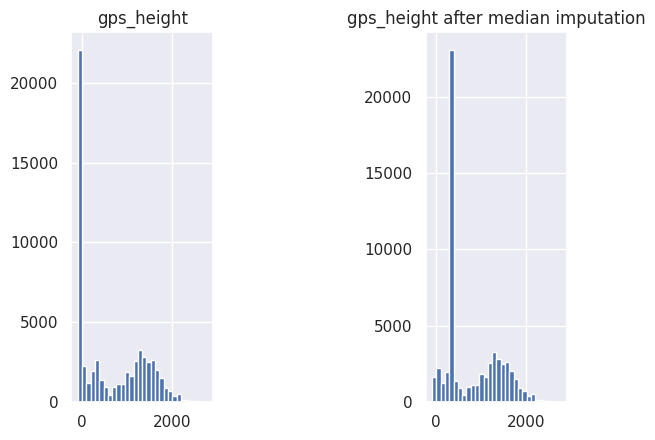

In [12]:
# 3. gps_height
# replace 0 with median
water_pump_data['gps_height_new'] = water_pump_data['gps_height'].replace(to_replace=0, value=water_pump_data['gps_height'].median())

plt.subplot(1, 2, 1)
plt.hist(water_pump_data['gps_height'], bins=30)
plt.title('gps_height')

plt.subplot(1, 2, 2)
plt.hist(water_pump_data['gps_height_new'], bins=30)
plt.title('gps_height after median imputation')

plt.subplots_adjust(wspace=1.5)

# display plot
plt.show()

In [13]:
# 4. num_private. High number of 0's. Not sure about meaning. Drop this column later. 
# water_pump_data.drop(['num_private'], axis=1, inplace=True)


In [14]:
# 5. District code 
# probably partly captured by region_code and lat lon
# Leaving as it is.

In [15]:
def get_column_mean_of_region(region_code, column_name):
    data_without_zeros_in_col = water_pump_data[[column_name, 'region_code']][water_pump_data[column_name] != 0]
    available_region_codes = data_without_zeros_in_col['region_code'].unique().tolist()
    if region_code in available_region_codes:
        col_mean = data_without_zeros_in_col[column_name][data_without_zeros_in_col['region_code']==region_code].mean()
        return int(col_mean)
    else:
        return 0

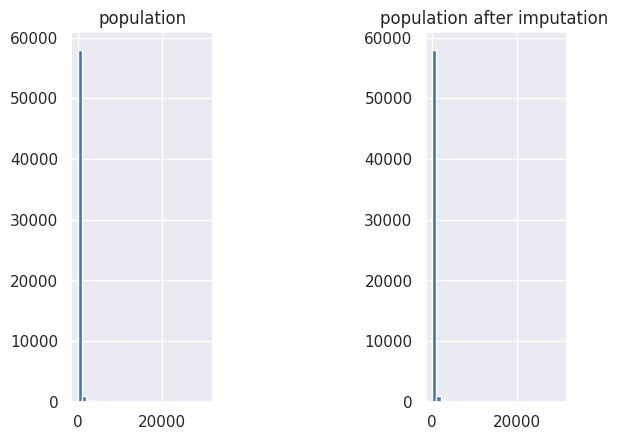

,population,population_new,region_code
4,0,200,18
6,0,428,17
7,0,428,17
8,0,150,14
9,0,200,18
...,...,...,...
59384,0,200,18
59392,0,150,12
59393,0,150,14
59397,0,150,12


In [16]:
# 6. Population. 
# Get the region and get the mean population from that region
# Then, the rest is imputed with the median

# Get population mean from region
water_pump_data['population_new'] = water_pump_data.apply(lambda row: get_column_mean_of_region(row['region_code'], 'population') if row['population'] == 0 else row['population'], axis=1)
# Impute 0 values with median
water_pump_data['population_new'] = water_pump_data['population_new'].replace(to_replace=0, value=water_pump_data['population_new'].median())

plt.subplot(1, 2, 1)
plt.hist(water_pump_data.population, bins=30)
plt.title('population')

plt.subplot(1, 2, 2)
plt.hist(water_pump_data.population_new, bins=30)
plt.title('population after imputation ')    

plt.subplots_adjust(wspace=1.5)

# display plot
plt.show()

# check if imputation worked
diff_rows = water_pump_data[['population', 'population_new', 'region_code']][water_pump_data['population'] != water_pump_data['population_new']]

# display the filtered DataFrame
display(diff_rows)

In [17]:
# 7. construction year: leave it as is


In [18]:
# 8. Longitude
# Get the region and get the mean population from that region
# Then, the rest is imputed with the median

# Get longitude mean from region
water_pump_data['longitude_new'] = water_pump_data.apply(lambda row: get_column_mean_of_region(row['region_code'], 'longitude') if row['longitude'] == 0 else row['longitude'], axis=1)
# Impute 0 values with median
water_pump_data['longitude_new'] = water_pump_data['longitude_new'].replace(to_replace=0, value=water_pump_data['longitude_new'].median())

# For all missing longitudes, the corresponding latitude is -2.e-08, replace with 0 first
water_pump_data['latitude'] = water_pump_data['latitude'].replace(-2.e-08, 0)
# Then replace 0's with mean latitude of the region
water_pump_data['latitude_new'] = water_pump_data.apply(lambda row: get_column_mean_of_region(row['region_code'], 'latitude') if row['latitude'] == 0 else row['latitude'], axis=1)
# Impute 0 values with median
water_pump_data['latitude_new'] = water_pump_data['latitude_new'].replace(to_replace=0, value=water_pump_data['latitude_new'].median())



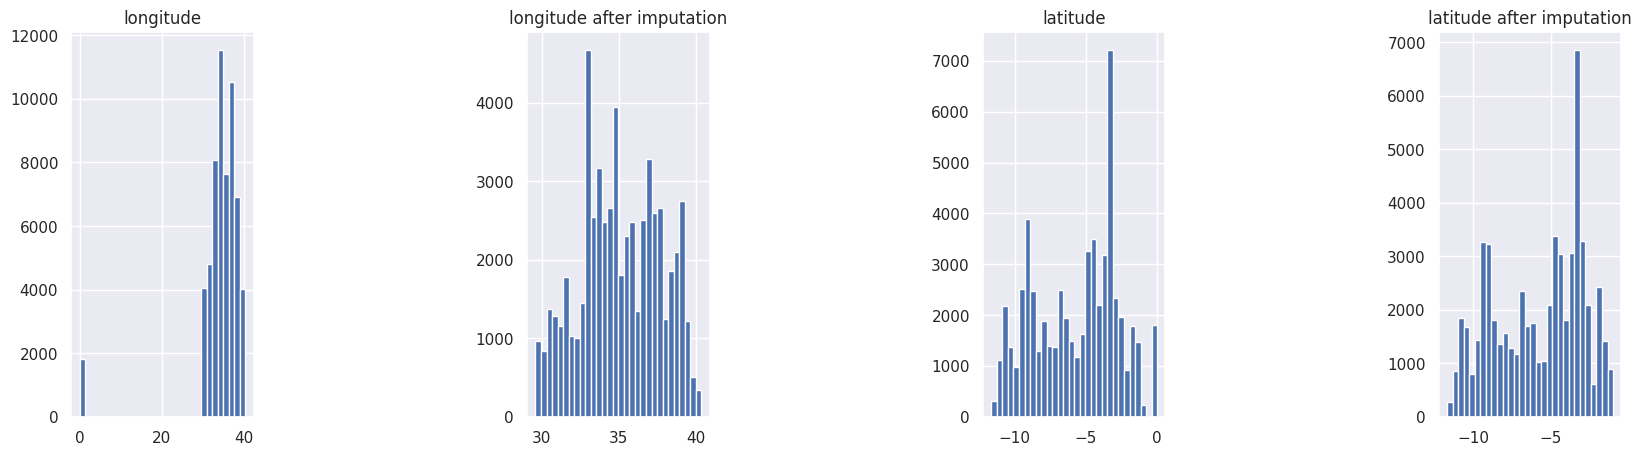

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,  figsize=(20, 5))
ax1.hist(water_pump_data.longitude, bins=30)
ax1.set_title('longitude')
ax2.hist(water_pump_data.longitude_new, bins=30)
ax2.set_title('longitude after imputation')
ax3.hist(water_pump_data.latitude, bins=30)
ax3.set_title('latitude')
ax4.hist(water_pump_data.latitude_new, bins=30)
ax4.set_title('latitude after imputation')


plt.subplots_adjust(wspace=1.5)

plt.show()

## 2.2 Categorical columns

In [20]:
# transform all strings to lowercase
water_pump_data = water_pump_data.applymap(lambda s: s.lower() if type(s) == str else s)

# transform strings like none or nan to np.nan
water_pump_data = water_pump_data.replace({'none': np.nan, 'nan': np.nan, '0': np.nan})

# replace '[' and ']' with ''
water_pump_data = water_pump_data.replace({'\[': ' ', '\]': ' ', '  ': ''}, regex=True)

# get categorical columns
cat_cols = water_pump_data.select_dtypes(include='object').columns

# get missing values
cat_missing_values = water_pump_data[cat_cols].isna().sum()

# sort the missing values count by column in descending order
missing_values_count_sorted = cat_missing_values.sort_values(ascending=False)
missing_values_count_sorted

scheme_name              28835
installer                 4432
funder                    4414
scheme_management         3878
wpt_name                  3565
public_meeting            3334
permit                    3056
subvillage                 371
quality_group                0
quantity                     0
quantity_group               0
source                       0
payment_type                 0
source_type                  0
source_class                 0
waterpoint_type              0
waterpoint_type_group        0
water_quality                0
extraction_type_class        0
payment                      0
management_group             0
management                   0
extraction_type_group        0
extraction_type              0
recorded_by                  0
ward                         0
lga                          0
region                       0
basin                        0
status_group                 0
dtype: int64

### Strategies 

For categorical variables, we can treat missing values with one of the following methods:

1. Drop rows with missing values
2. Drop full column with missing values
3. Label as seperate category, i.e. 'missing'
4. Fill missing value with mode
5. Use a machine learning model to impute missing values

Since I am planning to use a decision tree approach , I will label all the missing values as a separate category as it can handle missing within the tree itself.

| Column | Meaning | Strategy # | Comment
| --- | --- | --- | --- | 
| scheme_name | Who operates the waterpoint | 3 | related to scheme management?
| scheme_management | Who operates the waterpoint | 3 | related to scheme_name ?|
| installer |  Organization that installed the well | 3 | high cardinality, overlaps with funder and installer
| funder |  Who funded the well | 3 | high cardinality (many categories), overlaps with installer and scheme_name
| wpt_name | Name of the waterpoint if there is one | 3 | extremely high cardinality, no other information 
| public_meeting | True/False| 3 | no other information available | 
| permit | If the waterpoint is permitted | 3 | No other information, leaving as it is
| subvillage | Geographic location | 3 |  extremely high cardinality, probably overlaps with other geo data


In [21]:
# replace NaN values with 'not_available'
water_pump_data.fillna(value='not_available', inplace=True)

# check for missing values
water_pump_data[cat_cols].isna().sum()


funder                   0
installer                0
wpt_name                 0
basin                    0
subvillage               0
region                   0
lga                      0
ward                     0
public_meeting           0
recorded_by              0
scheme_management        0
scheme_name              0
permit                   0
extraction_type          0
extraction_type_group    0
extraction_type_class    0
management               0
management_group         0
payment                  0
payment_type             0
water_quality            0
quality_group            0
quantity                 0
quantity_group           0
source                   0
source_type              0
source_class             0
waterpoint_type          0
waterpoint_type_group    0
status_group             0
dtype: int64

# 3. Outliers

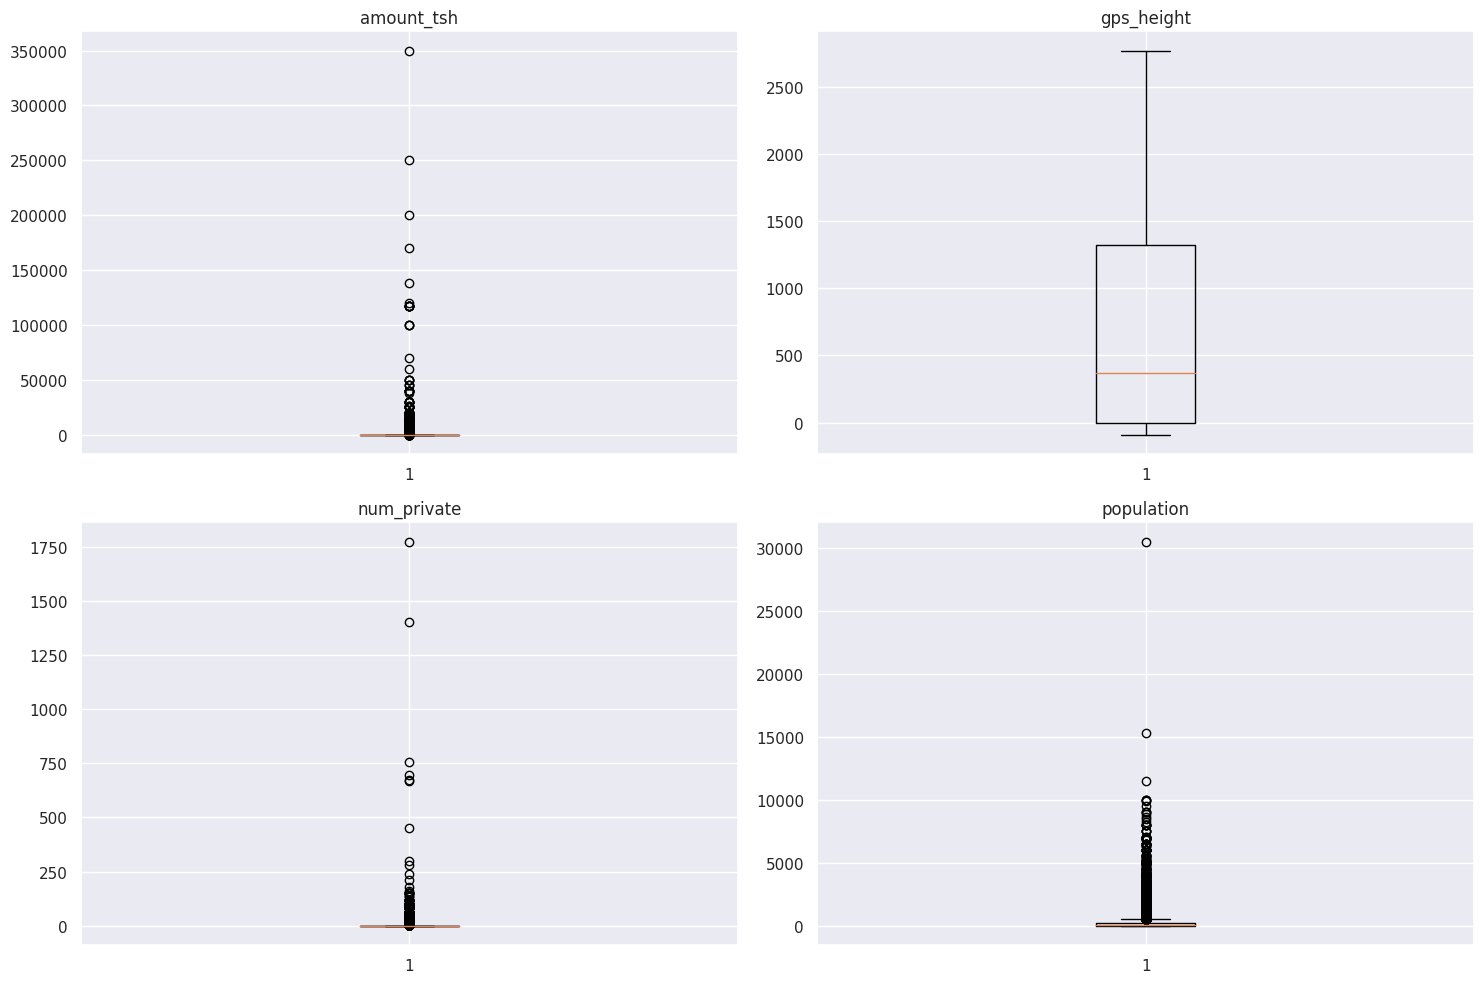

In [22]:
continuous_vars = ['amount_tsh', 'gps_height', 'num_private', 'population']

# plot the boxplots over two rows
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
for i, var in enumerate(continuous_vars):
    ax = axs[i//2, i%2]
    ax.boxplot(water_pump_data[var])
    ax.set_title(var)
plt.tight_layout()
plt.show()

### Strategies

1. Remove outlier (if it's data entry error or data processing error, and you have a lot of data)
2. Discuss with domain expert 
3. Replace outlier with mean
4. Replace outlier with median
5. Dependent on the size of dataset, treat outliers separately during model fitting and build a different model to fit the outliers (but time consuming)
6. Leave as is. Don't drop an outlier if the results are critical or when there are a lot of outliers. 

I will go for strategy 6, as there are a lot of outliers I don't want to drop them. I also plan to go for a tree-based approach that are quite robust to outliers.

# 4. Normality, skewness and kurtosis

Most of the parametric machine learning models like regression based methods assume that the data is normally distributed. If this assumption fails the model fails to give accurate predictions.


- skewness: measures symmetry or asymmetry of data distribution. Data can be positive-skewed (data-pushed towards the right side) or negative-skewed (data-pushed towards the left side).
- kurtosis: measures whether data is heavy-tailed or light-tailed in a normal distribution. 



### Strategies

1. Square root transformation.
2. Cube root transformation.
3. Log transformations `np.log1p`
4. Box-cox transformations.

As I plan to use trees-based approach, algorithms based on decision trees are completely insensitive to the specific values of predictors, they react only to their order. So non-normality of the features is not an issue.



In [23]:
# numeric_feats = ['amount_tsh', 'gps_height', 'num_private', 'population']

# skewed_feats = water_pump_data[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
# high_skew = skewed_feats[abs(skewed_feats) > 0.5]
# high_skew

# for feature in high_skew.index:
#     water_pump_data[f"{feature}_new"] = np.log1p(np.abs(water_pump_data[feature]))

# 5. Multicollinearity

Colinearity is when two or more variables are a linear combination of one another. If there is perfect colinearity, then a variable can be completely explained as a linear combination of other variables. 

Multicollinearity is mostly an issue for multiple linear regression models. There, it can cause a variety of issues, including numerical instability, inflation of coefficient standard errors, overfitting, and the inability to accurately isolate and understand the effects of individual features.


### Strategies

Testing for multicollinearity
1. Correlation matrix
2. The Variance Inflation Factor. A VIF between 1 to 5 indicates low to moderate correlation, a VIF of over 5 may be a problem, and a VIF of over 10 is almost definitely a problem.
3. Lasso regression

Dealing with multicollinearity
1. Drop a variable
2. Combine or transform variables
3. Keep predictors in the model
4. Do nothing 

For nonparametric models such as decision trees, overfitting can occur if the level of correlation between features in the training set does not generalize to unseen data. Tree ensembles can deal better with this, especially when feature bagging (independent random samples of feature subsets used to build each tree) is employed, such as Random Forests and most modern Gradient Boosting implementations. 

It is in estimating feature importance when multicollinearity is an issue for trees based methods. The variable importance of a feature is increased whenever the model splits on the node. When two features are collinear, the variable importance of the features becomes diluted. 

Finally, it may possibly lead to some suboptimal, possibly redundant, splitting decisions depending on the learning algorithm


As some columns are duplicate of others and for time efficiency of building the model, I will drop columns with duplicate data and columns with high number of categories later.

In [24]:

# # Fill diagonal and upper half with NaNs
# mask = np.zeros_like(water_pump_data_corr, dtype=bool)
# mask[np.triu_indices_from(mask)] = True
# water_pump_data_corr[mask] = np.nan
# (water_pump_data_corr
#  .style
#  .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
#  .highlight_null(color='#f1f1f1')  # Color NaNs grey
#  .format(precision=2))

# plt.show()

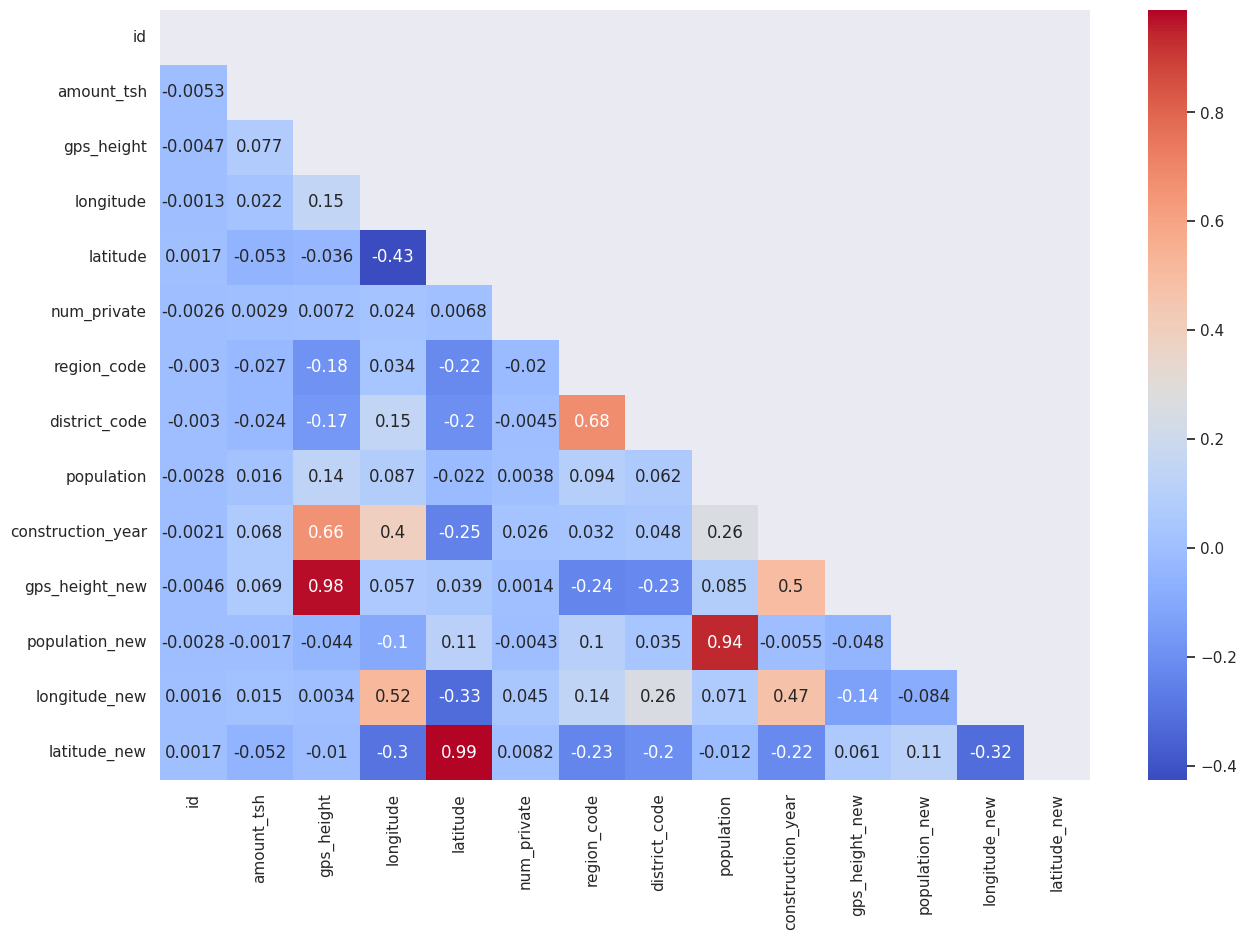

In [25]:
water_pump_data_corr = water_pump_data.corr(numeric_only=True)

plt.figure(figsize=(15,10))

# create a boolean mask to hide the upper half
mask = np.zeros_like(water_pump_data_corr)
mask[np.triu_indices_from(mask)] = True

# plot the correlation matrix with Seaborn
sns.heatmap(water_pump_data_corr, cmap='coolwarm', annot=True, mask=mask)

plt.show()

In [26]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

In [27]:
X = water_pump_data[cont_cols].iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,id,3.623314
1,amount_tsh,1.020714
2,gps_height,2.115382
3,longitude,10.016489
4,latitude,6.109425
5,num_private,1.002700
6,region_code,3.280050
7,district_code,2.524888
8,population,1.189516


# 6. Deal with high-cardinality



### Strategies

1. Use a aggregation function. Leave instances to a value with high frequence and replace others with a category that is 'other'
2. Use binary encoding to reduce dimensionality. 
3. Use target encoding (may lead to target leakage)
4. Use mean/count encoding
5. Bin or combine data into groups. This may require domain knowledge. The idea is to reduce the number of unique values by grouping them into sets that make sense. (may impair model performance or explainability)


In [28]:
def aggregate_categories(column, threshold=50):
    
    # count the number of occurrences of each unique value in column 
    value_counts = water_pump_data[column].value_counts()
    
    # replace values with 'other' that are not in the top threshold categories
    if len(value_counts) > threshold:
        replace_values = value_counts[threshold:].index
        return water_pump_data[column].replace(replace_values, 'other')
    else:
        return water_pump_data[column]

In [29]:
# Using strategy 5 for funder and installer
water_pump_data['funder'] = aggregate_categories('funder', 30)
water_pump_data['installer'] = aggregate_categories('installer', 30) 


In [30]:
# create a list to store dataframes
result_df = []

for col in cat_cols:
    unique_values = water_pump_data[col].nunique()
    temp_df = pd.DataFrame({'Column': [col], 'Unique Values': [unique_values]})
    result_df.append(temp_df)
    
# concatenate all dataframes together
result_df = pd.concat(result_df, ignore_index=True)
    
# sort result dataframe by number of unique values in descending order
result_df = result_df.sort_values('Unique Values', ascending=False)

# print result dataframe
display(result_df)

,Column,Unique Values
2,wpt_name,37399
4,subvillage,19288
11,scheme_name,2576
7,ward,2092
6,lga,125
0,funder,31
1,installer,31
5,region,21
13,extraction_type,18
14,extraction_type_group,13


I also drop columns with extremely high cardinality, everything with more than 2000 categories

In [31]:
def find_num_overlapping_cols(col1, col2, col3=None):
    
    if col3:
        print(f"categories {col1}: {water_pump_data[col1].nunique()}, {col2}: {water_pump_data[col2].nunique()}, {col3}: {water_pump_data[col3].nunique()}")
        num_overlap = len(water_pump_data[[col1, col2]].loc[(water_pump_data[col1] == water_pump_data[col2]) == water_pump_data[col3]])
    else:
        print(f"categories {col1}: {water_pump_data[col1].nunique()}, {col2}: {water_pump_data[col2].nunique()}")
        num_overlap = len(water_pump_data[[col1, col2]].loc[(water_pump_data[col1] == water_pump_data[col2])])
    print(f"rows with same value: {num_overlap}")
    print("")


In [32]:
## check for overlapping columns

find_num_overlapping_cols('funder', 'installer') # keep funder, since less categories

find_num_overlapping_cols('extraction_type', 'extraction_type_class')  

find_num_overlapping_cols('extraction_type', 'extraction_type_group') # Keep extraction_type_group, 13 classes
find_num_overlapping_cols('extraction_type_class', 'extraction_type_group') # BIG OVERLAP, remove extraction_type since there are so many classes (18)
find_num_overlapping_cols('extraction_type', 'extraction_type_class', 'extraction_type_group') # drop extraction_type, and extraction_type_class

find_num_overlapping_cols('waterpoint_type', 'waterpoint_type_group') # drop waterpoint_type_group (one more extra class can perhaps be more precise)

find_num_overlapping_cols('region', 'region_code') # drop region_code, 21 region vs 27 region codes
find_num_overlapping_cols('ward', 'lga') # drop ward
find_num_overlapping_cols('ward', 'lga', 'region_code')


find_num_overlapping_cols('scheme_name', 'scheme_management') #drop scheme_name, too many categories 2576
find_num_overlapping_cols('management', 'scheme_management') # drop scheme_management, overlap with management


find_num_overlapping_cols('payment', 'payment_type') # captures the same, drop 'payment'
find_num_overlapping_cols('management', 'scheme_management') # drop scheme_management, overlap with management
find_num_overlapping_cols('management', 'management_group') # drop management_group, only 5 categories

find_num_overlapping_cols('water_quality', 'quality_group') # quality might be important factor
find_num_overlapping_cols('basin', 'subvillage') # drop subvillage, too many categories: 19288

find_num_overlapping_cols('source_class', 'source') 
find_num_overlapping_cols('source_type', 'source') 
find_num_overlapping_cols('source_type', 'source_class') # remove source_type, keep source_class
find_num_overlapping_cols('waterpoint_type', 'waterpoint_type_group') # drop water_point_type_group


categories funder: 31, installer: 31
rows with same value: 25552

categories extraction_type: 18, extraction_type_class: 7
rows with same value: 37974

categories extraction_type: 18, extraction_type_group: 13
rows with same value: 56931

categories extraction_type_class: 7, extraction_type_group: 13
rows with same value: 39957

categories extraction_type: 18, extraction_type_class: 7, extraction_type_group: 13
rows with same value: 0

categories waterpoint_type: 7, waterpoint_type_group: 6
rows with same value: 53297

categories region: 21, region_code: 27
rows with same value: 0

categories ward: 2092, lga: 125
rows with same value: 844

categories ward: 2092, lga: 125, region_code: 27
rows with same value: 17

categories scheme_name: 2576, scheme_management: 12
rows with same value: 3573

categories management: 12, scheme_management: 12
rows with same value: 49336

categories payment: 7, payment_type: 7
rows with same value: 34559

categories management: 12, scheme_management: 12
ro

In [33]:
drop_cols = ['wpt_name', 'subvillage', 'scheme_name', 'ward']
water_pump_data.drop(drop_cols, axis=1, inplace=True)
display(water_pump_data.head())
print(water_pump_data.shape)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,num_private,basin,region,region_code,district_code,lga,population,public_meeting,recorded_by,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,gps_height_new,population_new,longitude_new,latitude_new
0,69572,6000.0,2011-03-14,other,1390,other,34.938093,-9.856322,0,lake nyasa,iringa,11,5,ludewa,109,True,geodata consultants ltd,vwc,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1390,109,34.938093,-9.856322
1,8776,0.0,2013-06-03,other,1399,other,34.698766,-2.147466,0,lake victoria,mara,20,2,serengeti,280,not_available,geodata consultants ltd,other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1399,280,34.698766,-2.147466
2,34310,25.0,2013-02-25,other,686,world vision,37.460664,-3.821329,0,pangani,manyara,21,4,simanjiro,250,True,geodata consultants ltd,vwc,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,686,250,37.460664,-3.821329
3,67743,0.0,2013-01-28,unicef,263,other,38.486161,-11.155298,0,ruvuma / southern coast,mtwara,90,63,nanyumbu,58,True,geodata consultants ltd,vwc,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,263,58,38.486161,-11.155298
4,19728,0.0,2011-07-13,other,0,other,31.130847,-1.825359,0,lake victoria,kagera,18,1,karagwe,0,True,geodata consultants ltd,not_available,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,369,200,31.130847,-1.825359


(59400, 41)


# 7. Feature Engineering 

In [34]:
# perhaps the regularity of the inspection can also say something about the
water_pump_data['year_recorded'] = water_pump_data.date_recorded.dt.year

# 8. Drop columns

Drop columns that are not relevant for classification of the pump, those that overlap with others and the original columns which we imputed missing values.

In [35]:
drop_cols = ['id', 'date_recorded','gps_height', 'population', 'longitude', 'latitude', 'installer', 'extraction_type', 'extraction_type_class', 'waterpoint_type_group', 'region_code', 'scheme_management', 'management_group', 'payment', 'recorded_by']
water_pump_data.drop(drop_cols, axis=1, inplace=True)

In [36]:
replace_column_names={
    "population_new": "population",
    "longitude_new": "longitude",
    "latitude_new": "latitude"
}
water_pump_data=water_pump_data.rename(columns=replace_column_names)
water_pump_data.head()

,amount_tsh,funder,num_private,basin,region,district_code,lga,public_meeting,permit,construction_year,extraction_type_group,management,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,status_group,gps_height_new,population,longitude,latitude,year_recorded
0,6000.0,other,0,lake nyasa,iringa,5,ludewa,True,False,1999,gravity,vwc,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,functional,1390,109,34.938093,-9.856322,2011
1,0.0,other,0,lake victoria,mara,2,serengeti,not_available,True,2010,gravity,wug,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,1399,280,34.698766,-2.147466,2013
2,25.0,other,0,pangani,manyara,4,simanjiro,True,True,2009,gravity,vwc,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,functional,686,250,37.460664,-3.821329,2013
3,0.0,unicef,0,ruvuma / southern coast,mtwara,63,nanyumbu,True,True,1986,submersible,vwc,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,non functional,263,58,38.486161,-11.155298,2013
4,0.0,other,0,lake victoria,kagera,1,karagwe,True,True,0,gravity,other,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,functional,369,200,31.130847,-1.825359,2011


In [37]:
# save dataset
water_pump_data.to_csv('../data/processed/water_pump_dataset.csv', index=False)

In [38]:
# save dataset
water_pump_data.to_csv('../data/processed/water_pump_dataset.csv', index=False)

# 8. Encode dataset

In [39]:
# create dummies for all categorical columns
cat_cols = water_pump_data.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('status_group')

# create dummies
water_pump_data = pd.get_dummies(water_pump_data, columns = cat_cols)

In [40]:
# Map target
target_map = {
    "functional": 0,
    "non functional": 1,
    "functional needs repair": 2 
}

water_pump_data['status_group']=water_pump_data['status_group'].map(target_map)

In [41]:
water_pump_data.head()

,amount_tsh,num_private,district_code,construction_year,status_group,gps_height_new,population,longitude,latitude,year_recorded,funder_adb,funder_amref,funder_danida,funder_dhv,funder_district council,funder_dwe,funder_dwsp,funder_fini water,funder_germany republi,funder_government of tanzania,funder_hesawa,funder_hifab,funder_isf,funder_kkkt,funder_lga,funder_ministry of water,funder_netherlands,funder_norad,funder_not_available,funder_other,funder_oxfam,funder_private individual,funder_rc church,funder_rwssp,funder_tasaf,funder_tcrs,funder_unicef,funder_water,funder_wateraid,funder_world bank,funder_world vision,basin_internal,basin_lake nyasa,basin_lake rukwa,basin_lake tanganyika,basin_lake victoria,basin_pangani,basin_rufiji,basin_ruvuma / southern coast,basin_wami / ruvu,region_arusha,region_dar es salaam,region_dodoma,region_iringa,region_kagera,region_kigoma,region_kilimanjaro,region_lindi,region_manyara,region_mara,region_mbeya,region_morogoro,region_mtwara,region_mwanza,region_pwani,region_rukwa,region_ruvuma,region_shinyanga,region_singida,region_tabora,region_tanga,lga_arusha rural,lga_arusha urban,lga_babati,lga_bagamoyo,lga_bahi,lga_bariadi,lga_biharamulo,lga_bukoba rural,lga_bukoba urban,lga_bukombe,lga_bunda,lga_chamwino,lga_chato,lga_chunya,lga_dodoma urban,lga_geita,lga_hai,lga_hanang,lga_handeni,lga_igunga,lga_ilala,lga_ileje,lga_ilemela,lga_iramba,lga_iringa rural,lga_kahama,lga_karagwe,lga_karatu,lga_kasulu,lga_kibaha,lga_kibondo,lga_kigoma rural,lga_kigoma urban,lga_kilindi,lga_kilolo,lga_kilombero,lga_kilosa,lga_kilwa,lga_kinondoni,lga_kisarawe,lga_kishapu,lga_kiteto,lga_kondoa,lga_kongwa,lga_korogwe,lga_kwimba,lga_kyela,lga_lindi rural,lga_lindi urban,lga_liwale,lga_longido,lga_ludewa,lga_lushoto,lga_mafia,lga_magu,lga_makete,lga_manyoni,lga_masasi,lga_maswa,lga_mbarali,lga_mbeya rural,lga_mbinga,lga_mbozi,lga_mbulu,lga_meatu,lga_meru,lga_misenyi,lga_missungwi,lga_mkinga,lga_mkuranga,lga_monduli,lga_morogoro rural,lga_morogoro urban,lga_moshi rural,lga_moshi urban,lga_mpanda,lga_mpwapwa,lga_mtwara rural,lga_mtwara urban,lga_mufindi,lga_muheza,lga_muleba,lga_musoma rural,lga_mvomero,lga_mwanga,lga_nachingwea,lga_namtumbo,lga_nanyumbu,lga_newala,lga_ngara,lga_ngorongoro,lga_njombe,lga_nkasi,lga_nyamagana,lga_nzega,lga_pangani,lga_rombo,lga_rorya,lga_ruangwa,lga_rufiji,lga_rungwe,lga_same,lga_sengerema,lga_serengeti,lga_shinyanga rural,lga_shinyanga urban,lga_siha,lga_sikonge,lga_simanjiro,lga_singida rural,lga_singida urban,lga_songea rural,lga_songea urban,lga_sumbawanga rural,lga_sumbawanga urban,lga_tabora urban,lga_tandahimba,lga_tanga,lga_tarime,lga_temeke,lga_tunduru,lga_ukerewe,lga_ulanga,lga_urambo,lga_uyui,public_meeting_False,public_meeting_True,public_meeting_not_available,permit_False,permit_True,permit_not_available,extraction_type_group_afridev,extraction_type_group_gravity,extraction_type_group_india mark ii,extraction_type_group_india mark iii,extraction_type_group_mono,extraction_type_group_nira/tanira,extraction_type_group_other,extraction_type_group_other handpump,extraction_type_group_other motorpump,extraction_type_group_rope pump,extraction_type_group_submersible,extraction_type_group_swn 80,extraction_type_group_wind-powered,management_company,management_other,management_other - school,management_parastatal,management_private operator,management_trust,management_unknown,management_vwc,management_water authority,management_water board,management_wua,management_wug,payment_type_annually,payment_type_monthly,payment_type_never pay,payment_type_on failure,payment_type_other,payment_type_per bucket,payment_type_unknown,water_quality_coloured,water_quality_fluoride,water_quality_fluoride abandoned,water_quality_milky,water_quality_salty,water_quality_salty abandoned,water_quality_soft,water_quality_unknown,quality_group_colored,quality_group_fluoride,quality_group_good,quality_group_milky,quality_group_salty,quality_group_unknown,quantity_dry,quantity_enough,quantity_insufficient,quantity

# 9. Export dataset 

In [42]:
# Save 
water_pump_data.to_csv('../data/processed/water_pump_dataset_encoded.csv', index=False)